# Segmenting and Clustering Neighborhoods in Toronto
## Part 3

Import libraries.

In [41]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
from sklearn.cluster import KMeans

Read the CSV created in Part 2 that I downloaded.

In [42]:
df = pd.read_csv('toronto_coords.csv')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


Get the coordinates of Toronto.

In [43]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Create a map of Toronto and add all the Neighborhoods from the dataframe.

In [44]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Let's only focus on the Boroughs that contain Toronto.

In [45]:
toronto_boro = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(toronto_boro.shape)
toronto_boro.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [46]:
map_toronto_boro = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_boro['Latitude'], toronto_boro['Longitude'], toronto_boro['Borough'], toronto_boro['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_boro)  

map_toronto_boro

Use the FourSquare API to explore neighborhoods and segment them.

In [47]:
CLIENT_ID = 'X' # your Foursquare ID
CLIENT_SECRET = 'X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Create a function to get all the venues within a 500 metre radius of our Neighborhoods.

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the function we created above putting all the venues into a new dataframe.

In [49]:
toronto_venues = getNearbyVenues(names=toronto_boro['Neighborhood'],
                                   latitudes=toronto_boro['Latitude'],
                                   longitudes=toronto_boro['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

Check the size and layout of the dataframe just created.

In [50]:
print(toronto_venues.shape)
toronto_venues.head()

(1572, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


How many venues were returned for each venue.

In [51]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36
Davisville North,8,8,8,8,8,8


Find out how many unique types of venue there are.

In [52]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


To cluster the neighborhoods the venues associated with each one needs to be transposed to it's own column, this can be done using one hot encoding.

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
ne = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1, inplace = True)
toronto_onehot.insert(0, 'Neighborhood', ne)

toronto_onehot.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group rows by neighborhood and calculate the mean of the frequency of occurrence of each category.

In [54]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.017544,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.017544,0.035088,0.000000,0.000000,0.0,0.017544,0.017544,0.0,0.035088,0.0,0.017544,0.000000,0.017544,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.017544,0.0,0.0000,0.0,0.035088,0.0,0.0,0.0,0.000000,0.017544,0.052632,0.087719,0.0,0.0,0.0,0.0,0.017544,0.000000,0.017544,0.000000,0.0,0.0,0.017544,0.0,0.0,0.0,0.000000,0.017544,0.000000,0.017544,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017544,0.0,0.0,0.0,0.0,0.000000,0.035088,0.0,0.0,0.0,0.017544,0.0

Create a function to sort venues in descending order.

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe and display the top 10 venues for each neighborhood.

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Bakery,Beer Bar,Pharmacy,Restaurant,Sporting Goods Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Bakery,Intersection,Stadium,Bar,Restaurant,Italian Restaurant,Furniture / Home Store
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Harbor / Marina,Airport Food Court,Airport Gate,Airport Terminal,Plane,Airport,Boutique,Sculpture Garden
3,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Bubble Tea Shop,Burger Joint,Salad Place,Deli / Bodega,Diner,Dessert Shop
4,Christie,Grocery Store,Café,Park,Coffee Shop,Candy Store,Baby Store,Italian Restaurant,Athletics & Sports,Nightclub,Restaurant
5,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Fast Food Restaurant,Hotel,Mediterranean Restaurant,Men's Store,Pizza Place
6,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,Seafood Restaurant,Japanese Restaurant,American Restaurant,Deli / Bodega
7,Davisville,Pizza Place,Sandwich Place,Dessert Shop,Thai Restaurant,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Café,Restaurant
8,Davisville North,Breakfast Spot,Gym / Fitness Center,Gym,Food & Drink Shop,Hotel,Park,Sandwich Place,Department Store,Adult Boutique,Molecular Gastronomy Restaurant
9,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Music Venue,Park,Bar,Café,Supermarket,Bank,Middle Eastern Restaurant,Grocery Store


## Clustering neighborhoods

Import libraries for clustering and plotting the K means elbow graph

In [57]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [58]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

Plot an elbow graph to estimate the optimal number for K in the K Neighbours Classifier

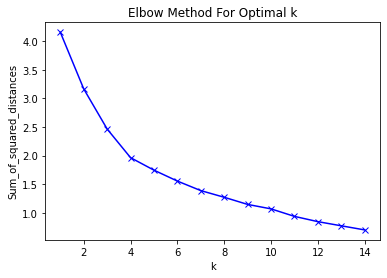

In [62]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like 4 is the optimal number.

Run k-means to cluster the neighborhood into 4 clusters.

In [63]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 1,
       0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [64]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_boro.merge(neighborhoods_venues_sorted, how='inner', on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Brewery,Spa,Shoe Store
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Theater,Electronics Store,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Cocktail Bar,Hotel,Cosmetics Shop,Park,Clothing Store,Seafood Restaurant,Creperie,Italian Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Pub,Trail,Music Venue,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Bakery,Beer Bar,Pharmacy,Restaurant,Sporting Goods Shop


Plot the clusters on a map of Toronto.

In [65]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
Dark2 = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=Dark2[cluster-1],
        fill=True,
        fill_color=Dark2[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

Cluster 0

In [66]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
cluster0.drop(labels=['PostalCode', 'Latitude', 'Longitude'], axis=1)

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",0,Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Brewery,Spa,Shoe Store
1,Downtown Toronto,"Garden District, Ryerson",0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Theater,Electronics Store,Pizza Place
2,Downtown Toronto,St. James Town,0,Café,Coffee Shop,Cocktail Bar,Hotel,Cosmetics Shop,Park,Clothing Store,Seafood Restaurant,Creperie,Italian Restaurant
3,East Toronto,The Beaches,0,Health Food Store,Pub,Trail,Music Venue,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
4,Downtown Toronto,Berczy Park,0,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Bakery,Beer Bar,Pharmacy,Restaurant,Sporting Goods Shop
5,Downtown Toronto,Central Bay Street,0,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Bubble Tea Shop,Burger Joint,Salad Place,Deli / Bodega,Diner,Dessert Shop
6,Downtown Toronto,Christie,0,Grocery Store,Café,Park,Coffee Shop,Candy Store,Baby Store,Italian Restaurant,Athletics & Sports,Nightclub,Restaurant
7,Downtown Toronto,"Richmond, Adelaide, King",0,Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Clothing Store,Gym,Salad Place,Cosmetics Shop,Concert Hall
8,West Toronto,"Dufferin, Dovercourt Village",0,Pharmacy,Bakery,Music Venue,Park,Bar,Café,Supermarket,Bank,Middle Eastern Restaurant,Grocery Store
10,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Sporting Goods Shop,Scenic Lookout,Fried Chicken Joint,Brewery,Park


Cluster 1

In [67]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
cluster1.drop(labels=['PostalCode', 'Latitude', 'Longitude'], axis=1)

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",1,Tennis Court,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant


Cluster 2

In [68]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
cluster2.drop(labels=['PostalCode', 'Latitude', 'Longitude'], axis=1)

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,2,Garden,Home Service,Adult Boutique,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant


Cluster 3

In [69]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
cluster3.drop(labels=['PostalCode', 'Latitude', 'Longitude'], axis=1)

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,The Danforth East,3,Park,Convenience Store,Metro Station,Adult Boutique,Music Venue,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
18,Central Toronto,Lawrence Park,3,Park,Swim School,Bus Line,Adult Boutique,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
21,Central Toronto,Forest Hill North & West,3,Park,Trail,Sushi Restaurant,Jewelry Store,Adult Boutique,Movie Theater,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant
33,Downtown Toronto,Rosedale,3,Park,Playground,Trail,Music Venue,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
